In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

from fastai import *
from fastai.vision import *
from superRes.generators import *
from superRes.critics import *
from superRes.dataset import *
from superRes.loss import *
from superRes.save import *
from superRes.fid_loss import *
from superRes.ssim import *
from superRes.metrics import *

import torchvision
import geffnet # efficient/ mobile net
from torchvision.models import vgg16_bn

In [2]:
def do_fit(learn, epochs,save_name, lrs=slice(1e-3), pct_start=0.9):
    learn.fit_one_cycle(epochs, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=20)

In [7]:
path = Path('./dataset/')

path_fullRes = path/'DIV2K_train_HR'
path_lowRes_diff = path/'DIV2K_train_LR_difficult' # suffix "x4d" ~300px
path_lowRes_mild = path/'DIV2K_train_LR_mild' # suffix "x4m" ~300px
path_lowRes_x8 = path/'DIV2K_train_LR_x8' # suffix "x8" ~150px


path_lowRes_256 = path/'DIV2K_train_LR_256_QF20'
path_lowRes_512 = path/'DIV2K_train_LR_512_QF20'
path_lowRes_Full = path/'DIV2K_train_LR_Full_QF20'

proj_id = 'unet_superRes_mobileNet_FeatSSIM'

gen_name = proj_id + '_gen'
crit_name = proj_id + '_crit'

nf_factor = 2
pct_start = 1e-8

In [4]:
model = geffnet.mobilenetv3_rw
# model = models.resnet34
# model= geffnet.tf_efficientnet_b4

# 256px

In [5]:
bs=10
sz=256
lr = 1e-2
wd = 1e-3
epochs = 1

In [8]:
data_gen = get_DIV2k_data_QF(path_lowRes_256, path_fullRes, bs=8, sz=sz)

In [9]:
t = data_gen.valid_ds[0][1].data
t = torch.stack([t,t])


def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)


gram_matrix(t)

base_loss = F.l1_loss

vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

In [8]:
learn_gen = gen_learner_wide(data=data_gen,
                             gen_loss=feat_loss,
                             arch = model,
                             nf_factor=nf_factor)

In [9]:
wandbCallbacks = False

if wandbCallbacks:
    import wandb
    from wandb.fastai import WandbCallback
    config={"batch_size": bs,
            "img_size": (sz, sz),
            "learning_rate": lr,
            "weight_decay": wd,
            "num_epochs": epochs
    }
    wandb.init(project='SuperRes', config=config, id="gen_mobilenetV3_SSIM"+ datetime.now().strftime('_%m-%d_%H:%M'))

    learn_gen.callback_fns.append(partial(WandbCallback, input_type='images'))

In [10]:
learn_gen.load("/data/students_home/fmameli/repos/SuperRes/dataset/DIV2K_train_LR_Patches/64px/models/unet_superRes_mobilenetV3_Patches64px_gen_512px_0")

Learner(data=ImageDataBunch;

Train: LabelList (800 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: dataset/DIV2K_train_LR_256;

Valid: LabelList (100 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: dataset/DIV2K_train_LR_256;

Test: None, model=DynamicUnetWide(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): HardSwish()
      (3): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
           

In [11]:
learn_gen.metrics.append(SSIM_Metric())
learn_gen.metrics.append(LPIPS_Metric())
learn_gen.metrics.append(BRISQUE_Metric())
learn_gen.metrics.append(NIQE_Metric())

Setting up Perceptual loss...
Loading model from: /data/students_home/fmameli/anaconda3/envs/fastai/lib/python3.6/site-packages/perceptual_similarity/weights/v0.1/alex.pth
...[net-lin [alex]] initialized
...Done


In [12]:
# learn_gen.lr_find()
# learn_gen.recorder.plot()
# learn_gen.summary()

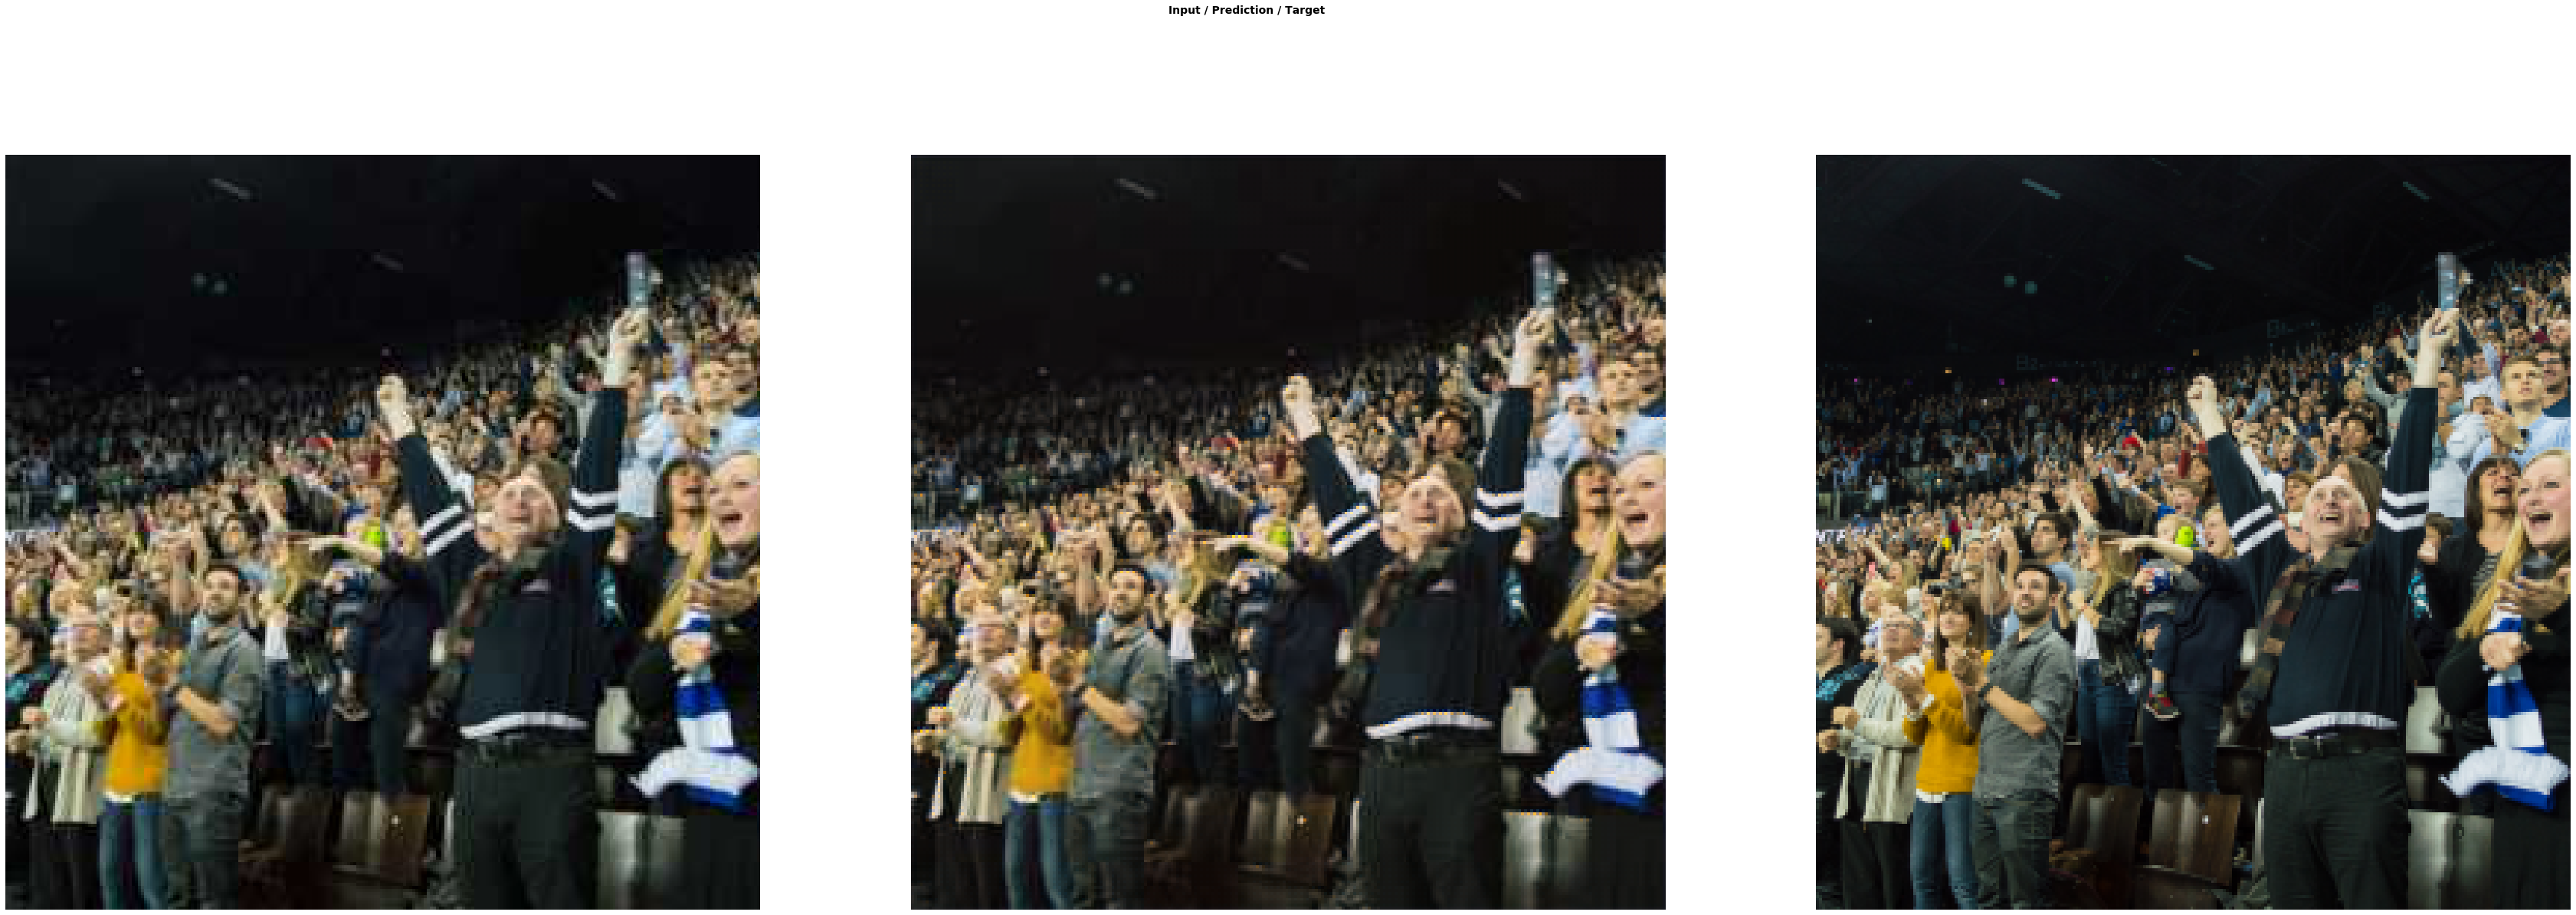

In [13]:
do_fit(learn_gen, epochs, gen_name+"_256px_0", slice(lr*10))

# 512px

In [14]:
bs=3
sz=512
epochs = 5

In [15]:
data_gen = get_DIV2k_data_QF(path_lowRes_512, path_fullRes, bs=bs, sz=sz)

In [16]:
learn_gen.data = data_gen
learn_gen.freeze()
gc.collect()

6491

In [17]:
# learn_gen.load(gen_name+"_256px_0")

In [18]:
# learn_gen.lr_find()
# learn_gen.recorder.plot()

Upsize to gen_512


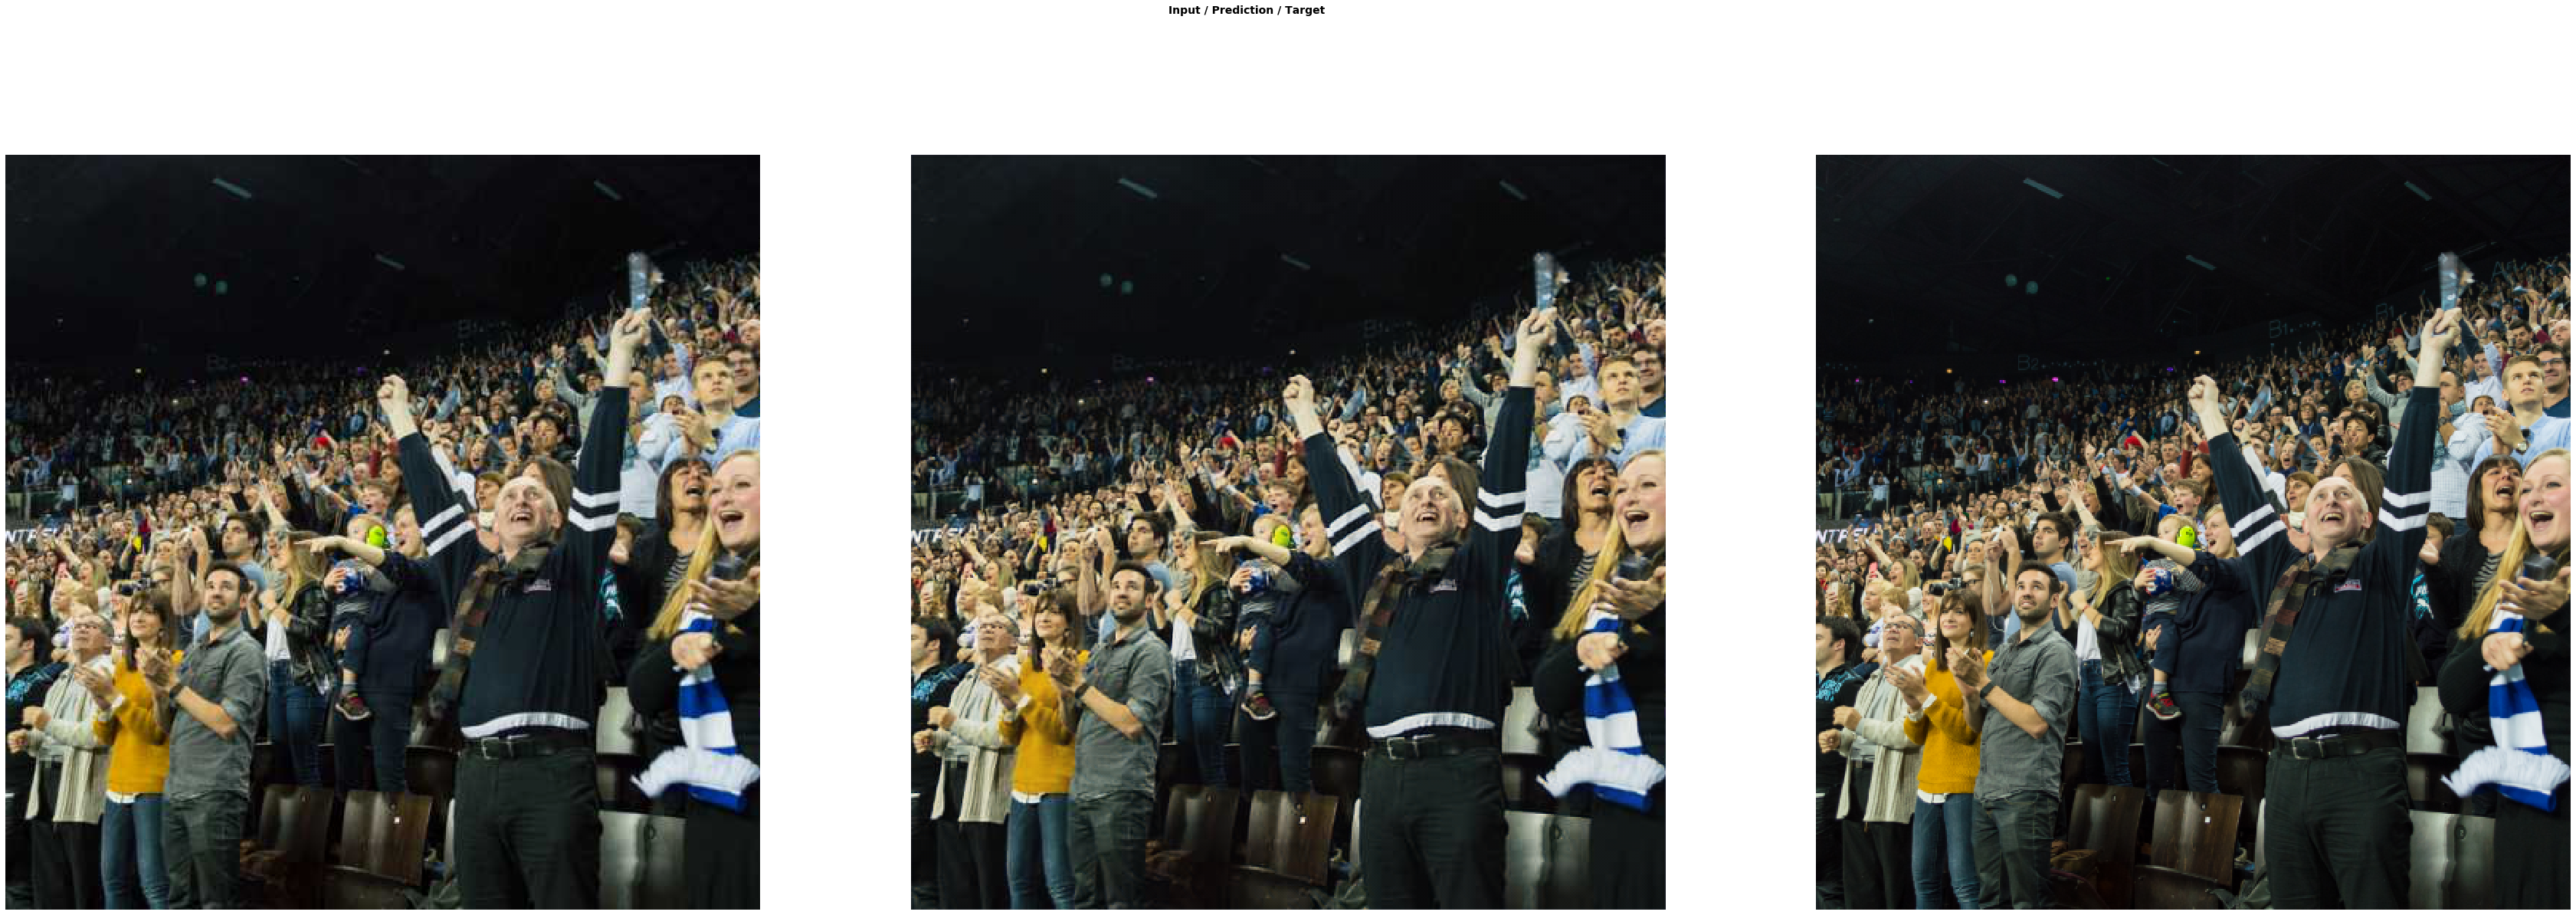

In [19]:
print("Upsize to gen_512")

do_fit(learn_gen, 1, gen_name+"_512px_0",slice(1e-2))

In [20]:
learn_gen.unfreeze()

In [21]:
# learn_gen.lr_find()
# learn_gen.recorder.plot()

In [ ]:
do_fit(learn_gen, 1, gen_name+"_512px_1", slice(1e-5))

In [ ]:
learn_gen.show_results(rows=1, imgsize=10)

In [14]:
learn_gen = gen_learner_wide(data=data_gen,
                             gen_loss= msssim,
                             arch = model,
                             nf_factor=nf_factor)
gc.collect()

8

In [17]:
learn_gen.load("unet_superRes_efficientNetB4_SSIM_gen_512px_1")

Learner(data=ImageDataBunch;

Train: LabelList (800 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: dataset/DIV2K_train_LR_x8;

Valid: LabelList (100 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: dataset/DIV2K_train_LR_x8;

Test: None, model=DynamicUnetWide(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): HardSwish()
      (3): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


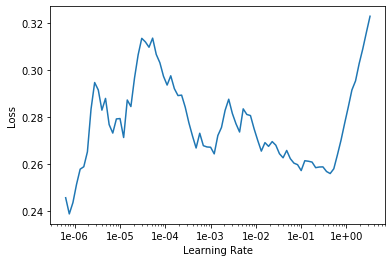

In [20]:
learn_gen.lr_find()
learn_gen.recorder.plot()

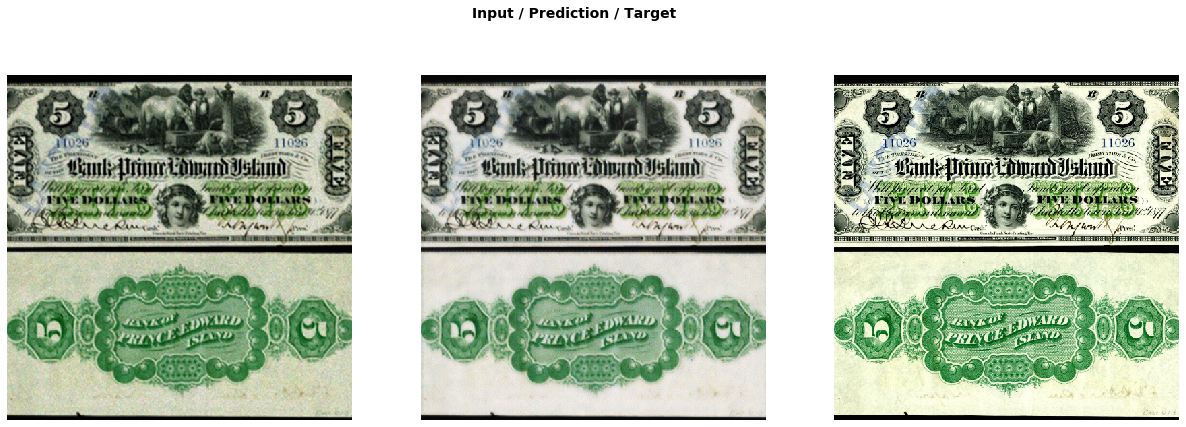

In [36]:
do_fit(learn_gen, 1, gen_name+"_512px_2",slice(1e-2))

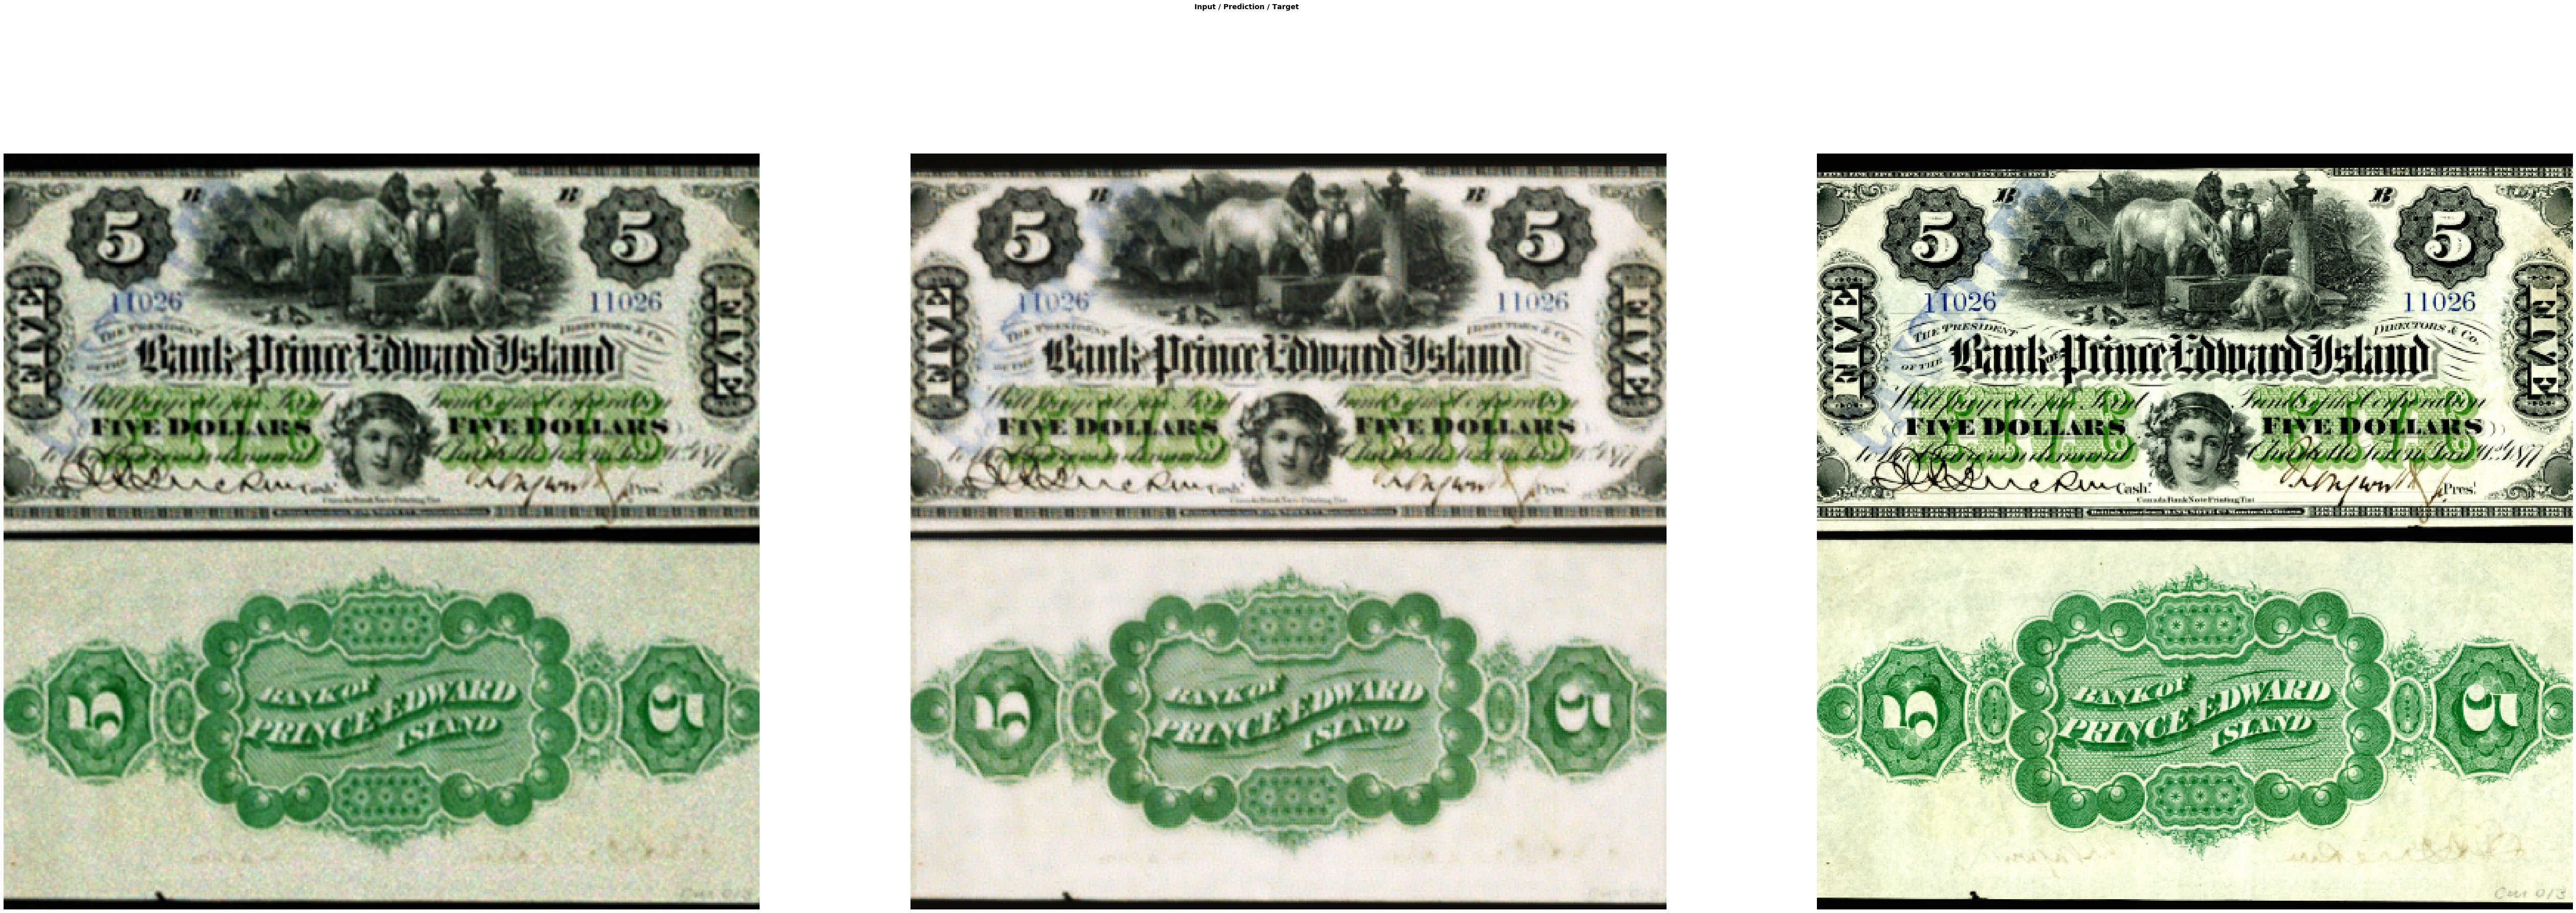

In [24]:
learn_gen.show_results(rows=1, imgsize=30)

torch.Size([3, 169, 255])


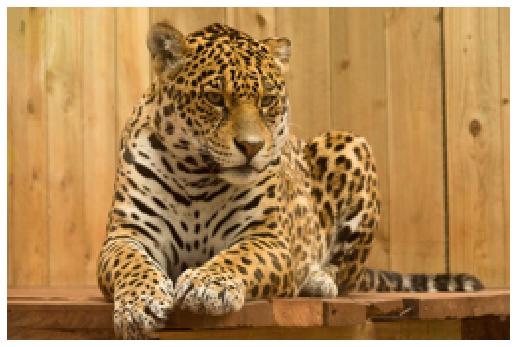

In [25]:
il = ImageList.from_folder(path_lowRes_x8)
print(il[10].shape)
il[10].show(figsize=(9,9))

Image (3, 512, 512)


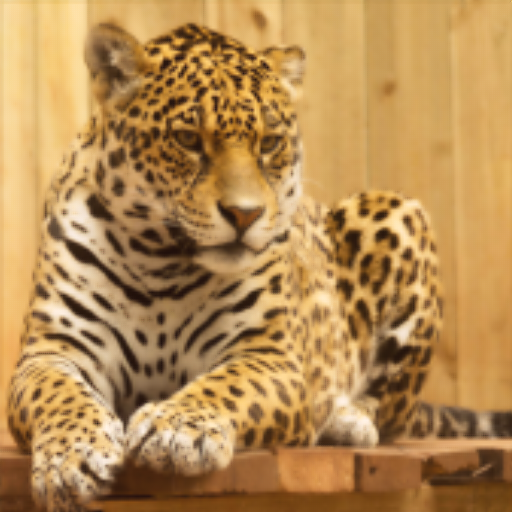

In [35]:
img = learn_gen.predict(il[10])
print(img[0])
img[0]